<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text Classification

Text classification is one of the most common tasks in NLP and can be used for applications
such as tagging customer feedback into categories or routing support tickets according to their
language. Chances are that your email’s spam filter is using text classification to protect your
inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which aims to identify the
polarity of a given text.

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express towards your company’s
product on Twitter. 

Until 2018, the deep learning approach to this problem typically involved
finding a suitable neural architecture for the task and training it from scratch on a dataset of
labeled tweets. This approach suffered from three major drawbacks:

- You needed a lot of labeled data to train accurate models like recurrent or
convolutional neural networks.
- Training these models from scratch was time consuming and expensive.
- The trained model could not be easily adapted to a new task, e.g. with a different set of labels.

Nowadays, these limitations are largely overcome via transfer learning, where typically a
Transformer-based architecture is pretrained on a generic task such as language modeling and
then reused for a wide variety of downstream tasks.

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [ ]:
!pip -q install umap-learn

In [ ]:
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from datasets import list_datasets, load_dataset

import torch
from torch.nn.functional import cross_entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, plot_confusion_matrix

import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##The Dataset

To build our emotion detector we’ll use a great dataset from an article that explored how
emotions are represented in English Twitter messages. 

Unlike most sentiment analysis datasets
that involve just “positive” and “negative” polarities, this dataset contains six basic emotions:
anger, disgust, fear, joy, sadness, and surprise. 


Given a tweet, our task will be to train a model
that can classify it into one of these emotions!

###Overview of Datasets

In [ ]:
# We can use the list_datasets function to see what datasets are available in the Hub:
datasets = list_datasets()

print(f"There are {len(datasets)} datasets currently available on the Hub.")
print(f"The first 10 are: {datasets[:10]}")

There are 2247 datasets currently available on the Hub.
The first 10 are: ['0n1xus/codexglue', '0n1xus/pytorrent-standalone', 'AConsApart/anime_subtitles_DialoGPT', 'AI-Sweden/SuperLim', 'AI-Sweden/super_glue_sv', 'AI-it/khs_service_test', 'AI-it/korean-hate-speech', 'ARKseal/YFCC14M_subset_webdataset', 'ARTeLab/fanpage', 'ARTeLab/ilpost']


We see that each dataset is given a name, so let’s inspect the metadata associated with the
emotion dataset:

In [ ]:
metadata = list_datasets(with_details=True)[datasets.index("emotion")]

# Show dataset description
print("Description:", metadata.description, "\n")
# Show first 8 lines of the citation string
print("Citation:", "\n".join(metadata.citation.split("\n")[:8]))

Description: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper. 

Citation: @inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",


This looks like the dataset we’re after, so next we can load it with the `load_dataset` function from Datasets:

In [ ]:
emotions = load_dataset("emotion")

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. 

And just like any dictionary, we can access an individual split as usual

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

This object behaves like an
ordinary Python container, so we can query its length

In [ ]:
len(train_ds)

16000

or access a single example by its index

In [ ]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a
dictionary, where the keys correspond to the column names

In [ ]:
train_ds.column_names

['text', 'label']

This reflects the fact that Datasets is
based on Apache Arrow, which defines a typed columnar format that is more memory efficient
than native Python. 

We can see what data types are being used under the hood by accessing the
features attribute of a Dataset object:

In [ ]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

We can also access several rows with a slice

In [ ]:
train_ds[:6]

{'label': [0, 0, 3, 2, 3, 0],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was']}

or get the full column by name

In [ ]:
train_ds["text"][:6]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was']

In each case the resulting data structure depends on the type of query; although this may feel
strange at first, it’s part of the secret sauce that makes Datasets so flexible!

###From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often
convenient to convert a Dataset object to a Pandas DataFrame so we can access highlevel
APIs for data visualization. 

To enable the conversion, Datasets provides a
`Dataset.set_format` function that allow us to change the output format of the Dataset.

This does not change the underlying data format which is Apache Arrow and you can switch to
another format later if needed:

In [ ]:
emotions.set_format(type="pandas")

df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As we can see, the column headers have been preserved and the first few rows match our
previous views of the data. 

However, the labels are represented as integers so let’s use the
`ClassLabel.int2str` function to create a new column in our DataFrame with the
corresponding label names:

In [ ]:
def label_int2str(row, split):
  return emotions[split].features["label"].int2str(row)

In [ ]:
df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


###Look at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the
distribution of examples among each class. 

For example, a dataset with a skewed class
distribution might require a different treatment in terms of the training loss and evaluation
metrics than a balanced one.

With Pandas and the visualisation library Matplotlib we can quickly visualize this as follows:

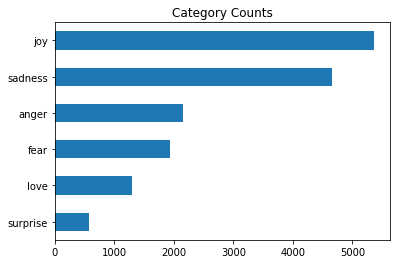

In [ ]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

We can see that the dataset is heavily imbalanced; the joy and sadness classes appear
frequently whereas love and sadness are about 5-10 times rarer.

There are several ways to
deal with imbalanced data such as resampling the minority or majority classes.

Alternatively, we can also weight the loss function to account for the underrepresented classes.

###How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the maximum context size. 

For most applications with BERT, the maximum context size is 512 tokens, where
a token is defined by the choice of tokenizer and can be a word, subword, or character. 

Let’s make a rough estimate of our tweet lengths per emotion by looking at the distribution of words per tweet:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


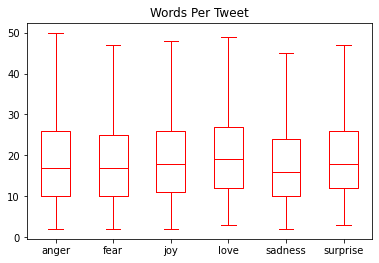

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="red", )
plt.suptitle("")
plt.xlabel("");

From the plot we see that for each emotion, most tweets are around 15 words long and the
longest tweets are well below BERT’s maximum context size of 512 tokens. 

Texts that are
longer than a model’s context window need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information. 

Let’s now figure out how we can
convert these raw texts into a format suitable for Transformers!

##Tokenization

Transformer models like BERT cannot receive raw strings as input; instead they assume the
text has been tokenized into numerical vectors. Tokenization is the step of breaking down a
string into the atomic units used in the model. 

There are several tokenization strategies one can
adopt and the optimal splitting of words in sub-units is usually learned from the corpus.

Before
looking at the tokenizer used for BERT, let’s motivate it by looking at two extreme cases:
character and word tokenizers.

###Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model. 

In Python, str objects are really arrays under the hood which allows us to quickly implement character-level tokenization with just one line of code:

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start but we are not yet done because our model expects each character to be
converted to an integer, a process called numericalization. 

One simple way to do this is by
encoding each unique token (which are characters in this case) with a unique integer:

In [ ]:
token2idx = {}
for idx, unique_char in enumerate(set(tokenized_text)):
  token2idx[unique_char] = idx

print(token2idx)

{'t': 0, 'o': 1, 'e': 2, 'T': 3, 'c': 4, 'L': 5, '.': 6, 's': 7, 'f': 8, 'z': 9, 'i': 10, 'x': 11, 'g': 12, 'k': 13, 'r': 14, ' ': 15, 'a': 16, 'P': 17, 'N': 18, 'n': 19}


In [ ]:
token2idx["e"]

2

In [ ]:
token2idx["c"]

4

This gives us a mapping from each character in our vocabulary to a unique integer, so we can
now use token2idx to transform the tokenized text to a list of integers:

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[3, 1, 13, 2, 19, 10, 9, 10, 19, 12, 15, 0, 2, 11, 0, 15, 10, 7, 15, 16, 15, 4, 1, 14, 2, 15, 0, 16, 7, 13, 15, 1, 8, 15, 18, 5, 17, 6]


We are almost done! Each token has been mapped to a unique, numerical identifier, hence the name `input_ids`.

The last step is to convert `input_ids` into a 2d tensor of one-hot vectors
which are better suited for neural networks than the categorical representation of `input_ids`.

The reason for this is that the elements of `input_ids` create an ordinal scale, so adding or subtracting two IDs is a meaningless operation since the result in a new ID that represents another random token.

On the other hand, the result of the adding two one-hot encodings can be
easily interpreted: the two entries that are “hot” indicate that the corresponding two tokens cooccur.
Each one-hot vector will have a length the size of the vocabulary and a “1” entry at the
position of each ID, with zeros everywhere else.

We can do this directly in PyTorch by converting `input_ids` to a `torch.Tensor`:

In [ ]:
input_ids = torch.tensor(input_ids)

one_hot_encodings = torch.nn.functional.one_hot(input_ids)
one_hot_encodings.shape

torch.Size([38, 20])

For each of the 38 input tokens we now have a one-hot vector of dimension 20 since our vocabularly consists of 20 unique characters.

By examining the first vector, we can verify that a
1 appears in the location indicated by `input_ids[0]`:

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot vector: {one_hot_encodings[0]}")

Token: T
Tensor index: 3
One-hot vector: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
print(f"Token: {tokenized_text[3]}")
print(f"Tensor index: {input_ids[3]}")
print(f"One-hot vector: {one_hot_encodings[3]}")

Token: e
Tensor index: 2
One-hot vector: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example, we can see that character-level tokenization ignores any structure in the texts such as words and treats them just as streams of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words
need to be learned, and that process requires significant compute and memory.

For this reason, character tokenization is rarely used in practice. Instead, some structure of the text such as
words is preserved during the tokenization step.

###Word Tokenization

Instead of splitting the text into characters, we can split it into words and map each word to an
integer. By using words from the outset, the model can skip the step of learning words from
characters and thereby eliminate complexity from the training process.

One simple class of word tokenizers uses whitespaces to tokenize the text. We can do this by
applying Python’s split function directly on the raw text:

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


However, we can already see one potential problem with this
tokenization scheme; punctuation is not accounted for, so NLP. is treated as a single token.
Given that words can include declinations, conjugations, or misspellings, the size of the
vocabulary can easily grow into the millions!

Words that are not part of the vocabulary are classified as “unknown” and
mapped to a shared UNK token. This means that we lose some potentially important information
in the process of word tokenization since the model has no information about which words
were associated with the UNK tokens.

Wouldn’t it be nice if there was a compromise between character and word tokenization that
preserves all input information and some of the input structure?

###Subword Tokenization

The idea behind subword tokenization is to take the best of both worlds from character and
word tokenization. On one hand, we want to use characters since they allow the model to deal
with rare character combinations and misspellings. On the other hand, we want to keep frequent
words and word parts as unique entities.

There are several subword tokenization algorithms such as Byte-Pair-Encoding, WordPiece,
Unigram, and SentencePiece.

The main distinguishing feature of subword tokenization (as well as word
tokenization) is that it is learned from the corpus used for pretraining.


The Transformers library provides a convenient
`from_pretrained` function that can be used to load both objects, either from the Hugging Face Model Hub or from a local path.

Let’s get started by loading the tokenizer for the DistilBERT model.

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

We can examine a few attributes of the tokenizer such as the vocabulary size:

In [ ]:
tokenizer.vocab_size

30522

We can also look at the special tokens used by the tokenizer, which differ from model to model.

For example, BERT uses the `[MASK]` token for the primary objective of masked language
modeling and the `[CLS]` and `[SEP]` tokens for the secondary pretraining objective of
predicting if two sentences are consecutive:

In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

Furthermore, the tokenizer stores the information of the corresponding model’s maximum
context sizes:

In [ ]:
tokenizer.model_max_length

512

Lets examine how the encoding and decoding of strings works in practice by first encoding a
test string:

In [ ]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

[101, 2023, 2003, 1037, 8552, 22199, 102]

Now that we have the
`input_ids`, we can convert them back into tokens by using the tokenizer’s
`convert_ids_to_tokens()` method:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

101 [CLS]
2023 this
2003 is
1037 a
8552 complicated
22199 ##test
102 [SEP]


The AutoTokenizer class has a `convert_tokens_to_string()` method for
remove the prefix etc., so let’s apply it to our tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[101, 2023, 2003, 1037, 8552, 3231, 102]

###Tokenizing the Whole Dataset

##Training a Text Classifier

BERT models are pretrained to predict masked words in a sequence
of text. However, we can’t use these language models directly for text classification, so instead
we need to modify them slightly.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/1.png?raw=1' width='800'/>

First, the text is tokenized and represented as one-hot vectors whose dimension is the size of
the tokenizer vocabulary, usually consisting of 50k-100k unique tokens. 

Next, these token
encodings are embedded in lower dimensions and passed through the encoder block layers to
yield a hidden state for each input token. 

For the pretraining objective of language modeling,
each hidden state is connected to a layer that predicts the token for the input token, which is
only non-trivial if the input token was masked. 

For the classification task, we replace the
language modeling layer with a classification layer. BERT sequences always start with a
classification token `[CLS]`, therefore we use the hidden state for the classification token as
input for our classification layer.

We have two options to train such a model on our Twitter dataset:
- Feature extraction
  - We use the hidden states as features and just train a classifier on them.
- Fine-tuning
  - We train the whole model end-to-end, which also updates the parameters of the pretrained BERT model.

In this section we explore both options for DistilBert and examine their trade-offs.

###Transformers as Feature Extractors

To use a Transformer as a feature extractor is fairly simple;we freeze
the body’s weights during training and use the hidden states as features for the classifier. 

The advantage of this approach is that we can quickly train a small or shallow model. Such a model
could be a neural classification layer or a method that does not rely on gradients such a Random Forest. 

This method is especially convenient if GPUs are unavailable since the hidden
states can be computed relatively fast on a CPU.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/2.png?raw=1' width='800'/>

The feature-based method relies on the assumption that the hidden states capture all the
information necessary for the classification task. However, if some information is not required
for the pretraining task, it may not be encoded in the hidden state, even if it would be crucial
for the classification task. 

In this case the classification model has to work with suboptimal
data, and it is better to use the fine-tuning approach.

####Using Pretrained Models

Since we want to avoid training a model from scratch we will also use the
`from_pretrained` function from Transformers to load a pretrained DistilBERT model:

In [ ]:
model = AutoModel.from_pretrained(model_name).to(device)

The `AutoModel` class corresponds to the input encoder that translates the one-hot vectors to
embeddings with positional encodings and feeds them through the encoder stack to return the
hidden states. 

The language model head that takes the hidden states and decodes them to the
masked token prediction is excluded since it is only needed for pretraining. 

If you want to use
that model head you can load the complete model with `AutoModelForMaskedLM`.

####Extracting the Last Hidden States

To warm up, let’s retrieve the last hidden states for a single string. To do that we first need to
tokenize the string.

In [ ]:
text = "this is a test"
text_tensor = tokenizer.encode(text, return_tensors="pt").to(device)

The resulting tensor has the shape `[batch_size, n_tokens]`:

In [ ]:
text_tensor.shape

torch.Size([1, 6])

We can now pass this tensor to the model to extract the hidden states. Depending on the model
configuration, the output can contain several objects such as the hidden states, losses, or
attentions, that are arranged in a class that is similar to a namedtuple in Python.

In our
example, the model output is a Python dataclass called BaseModelOutput, and like any
class, we can access the attributes by name. Since the current model returns only one entry
which is the last hidden state, let’s pass the encoded text and examine the outputs:

In [ ]:
output = model(text_tensor)
output.last_hidden_state.shape

torch.Size([1, 6, 768])

Looking at the hidden state tensor we see that it has the shape `[batch_size, n_tokens, hidden_dim]`. 

The way BERT works is that a hidden state is returned for each input, and the
model uses these hidden states to predict masked tokens in the pretraining task. 

For
classification tasks, it is common practice to use the hidden state associated with the `[CLS]`
token as the input feature, which is located at the first position in the second dimension.

####Tokenizing the Whole Dataset

Now that we know how to extract the hidden states for a single string, let’s tokenize the whole
dataset! 

To do this, we can write a simple function that will tokenize our examples

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

where `padding=True` will pad the examples with zeroes to the longest one in a batch, and
`truncation=True` will truncate the examples to the model’s maximum context size.

Previously, we set the output format of the dataset to "pandas" so that the accessed data is
returned as a DataFrame. 

We don’t need this output format anymore so we can now reset it
as follows:

In [ ]:
emotions.reset_format()

By applying the tokenize function on a small set of texts.

In [ ]:
tokenize(emotions["train"][:3])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

we see that the result is a dictionary, where each value is a list of lists generated by the
tokenizer. In particular, each sequence in input_ids starts with 101 and ends with 102,
followed by zeroes, corresponding to the `[CLS], [SEP]`, and `[PAD]` tokens respectively:

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/3.png?raw=1' width='800'/>

Also note that in addition to returning the encoded tweets as input_ids, the tokenizer also
returns list of attention_mask arrays. This is because we do not want the model to get
confused by the additional padding tokens, so the attention mask allows the model to ignore the
padded parts of the input.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/4.png?raw=1' width='800'/>

>For each batch, the input sequences are padded to the maximum sequence length in the batch. The attention mask is used in the model to ignore the padded areas of the input tensors.

To apply our tokenize function to the whole emotions corpus, we’ll use the
DatasetDict.map function. 

This will apply tokenize across all the splits in the corpus,
so our training, validation and test data will be preprocessed in a single line of code:

In [ ]:
# batch_size=None applies our tokenize function in one single batch and ensures that the input tensors and attention masks have the same shape globally
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

By default, `DatasetDict.map` operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches, while `batch_size=None` applies our tokenize function in one single batch and ensures that the input tensors and attention masks have the same shape globally. 

We can see that this operation has added two new features to the dataset: `input_ids` and the `attention mask`.

In [ ]:
emotions_encoded["train"].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
emotions_encoded["train"].features["attention_mask"]

Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)

In [ ]:
emotions_encoded["train"].features["input_ids"]

Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)

In [ ]:
emotions_encoded["train"].features["label"]

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

In [ ]:
emotions_encoded["train"].features["text"]

Value(dtype='string', id=None)

####From Input IDs to Hidden States

Now that we have converted our tweets to numerical inputs, the next step is to extract the last hidden states so that we can feed them to a classifier. 

If we had a single example we could simply pass the `input_ids` and `attention_mask` to the model as follows:

```python
hidden_states = model(input_ids, attention_mask)
```

but what we really want are the hidden states across the whole dataset. For this, we can use the `DatasetDict.map` function again! 

Let’s define a `forward_pass` function that takes a
batch of input IDs and attention masks, feeds them to the model, and adds a new
`hidden_state` feature to our batch:

In [ ]:
def forward_pass(batch):
  input_ids = torch.tensor(batch["input_ids"]).to(device)
  attention_mask = torch.tensor(batch["attention_mask"]).to(device)

  with torch.no_grad():
    last_hidden_state = model(input_ids, attention_mask).last_hidden_state
    last_hidden_state = last_hidden_state.cpu().numpy()

  # Use average of unmasked hidden states for classification
  lhs_shape = last_hidden_state.shape
  boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
  boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
  boolean_mask = boolean_mask.reshape(lhs_shape)
  masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
  batch["hidden_state"] = masked_mean.data

  return batch

In [ ]:
emotions_encoded = emotions_encoded.map(forward_pass, batched=True, batch_size=16)

As before, the application of DatasetDict.map has added a new hidden_state feature to our dataset:

In [ ]:
emotions_encoded["train"].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'hidden_state': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
labels_name= emotions_encoded["train"].features["label"]
labels_name.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

####Creating a Feature Matrix

The preprocessed dataset now contains all the information we need to train a clasifier on it. We
will use the hidden states as input features and the labels as targets. 

We can easily create the
corresponding arrays in the well known Scikit-Learn format as follows:

In [ ]:
x_train = np.array(emotions_encoded["train"]["hidden_state"])
x_valid = np.array(emotions_encoded["validation"]["hidden_state"])

y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])

x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

####Dimensionality Reduction with UMAP

Before we train a model on the hidden states, it is good practice to perform a sanity check that
they provide a useful representation of the emotions we want to classify. 

Since visualising the hidden states in 768 dimensions is tricky to say the least, we’ll use the powerful UMAP algorithm to project the vectors down to 2D. 

Since UMAP works best when the features are scaled to lie in the `[0,1]` interval, we’ll first apply a MinMaxScaler and then use UMAP to
reduce the hidden states:

In [ ]:
x_scaled = MinMaxScaler().fit_transform(x_train)
mapper = umap.UMAP(n_components=2, metric="cosine").fit(x_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,6.171368,4.949750,0
1,1.291876,5.069814,0
2,5.324743,2.073910,3
3,2.145481,3.395505,2
4,0.684688,7.421606,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! 

Let us investigate the compressed data a little bit further and
plot the density of points for each category separately:

In [ ]:
labels= emotions_encoded["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

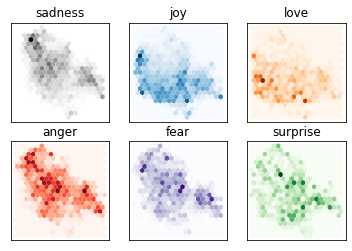

In [ ]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels= emotions_encoded["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

>These are only projections onto a lower dimensional space. Just because some categories overlap does not mean
that they are not separable in the original space. Conversely, if they are separable in the projected space they will
be separable in the original space.

Now there seem to be clearer patterns; the negative feelings such as sadness, anger and
fear all occupy a similar regions with slightly varying distributions. 

On the other hand, joy
and love are well separated from the negative emotions and also share a similar space.

Finally, surprise is scattered all over the place. We hoped for some separation but this in no
way guaranteed since the model was not trained to know the difference between this emotions
but learned them implicitly by predicting missing words.

####Training a Simple Classifier

We have seen that the hidden states are somewhat different between the emotions, although for
several of them there is not an obvious boundary. 

Let’s use these hidden states to train a simple
logistic regressor with Scikit-Learn! Training such a simple model is fast and does not require a GPU:

In [ ]:
lr_clf = LogisticRegression(n_jobs=-1, penalty="none")
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.6495

By looking at the accuracy it might appear that our model is just a bit better than random, but
since we are dealing with an unbalanced multiclass dataset this is significantly better than
random. We can get a better feeling for whether our model is any good by comparing against a
simple baseline.

In Scikit-Learn there is a `DummyClassifier` that can be used to build a
classifier with simple heuristics such as always choose the majority class or always draw a random class. In this case the best performing heuristic is to always choose the most frequent class:

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

which yields an accuracy of about 35%. So our simple classifier with BERT embeddings is
significantly better than our baseline.

We can further investigate the performance of the model
by looking at the confusion matrix of the classifier, which tells us the relationship between the
true and predicted labels:

In [ ]:
y_preds = lr_clf.predict(x_valid)
# plot_confusion_matrix(lr_clf, y_preds, y_valid, labels=labels);

We can see that anger and fear are most often confused with sadness, which agrees with
the observation we made when visualizing the embeddings. Also love and surprise are
frequently mistaken for joy.

To get an even better picture of the classification performance we can print Scikit-Learn’s
classification report and look at the precision, recall and F1-score for each class:

In [ ]:
print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.67      0.72      0.70       550
         joy       0.72      0.80      0.76       704
        love       0.54      0.34      0.41       178
       anger       0.57      0.49      0.53       275
        fear       0.52      0.55      0.54       212
    surprise       0.49      0.32      0.39        81

    accuracy                           0.65      2000
   macro avg       0.58      0.54      0.55      2000
weighted avg       0.64      0.65      0.64      2000



Now, we will explore the fine-tuning approach which leads to superior
classification performance. It is however important to note, that doing this requires much more
computational resources, such as GPUs, that might not be available in your company. 

In cases
like this, a feature-based approach can be a good compromise between doing traditional
machine learning and deep learning.

###Fine-tuning Transformers

Let’s now explore what it takes to fine-tune a Transformer end-to-end. With the fine-tuning
approach we do not use the hidden states as fixed features, but instead train them as shown.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/5.png?raw=1' width='800'/>

This requires the classification head to be differentiable, which is why this method
usually uses a neural network for classification. 

Since we retrain all the DistilBERT parameters,
this approach requires much more compute than the feature extraction approach and typically
requires a GPU.

Since we train the hidden states that serve as inputs to the classification model, we also avoid
the problem of working with data that may not be well suited for the classification task. 

Instead,
the initial hidden states adapt during training to decrease the model loss and thus increase its
performance. If the necessary compute is available, this method is commonly chosen over the
feature-based approach since it usually outperforms it.

We’ll be using the Trainer API from Transformers to simplify the training loop - let’s look at the ingredients we need to set one up!

####Loading a Pretrained Model

The first thing we need is a pretrained `DistilBERT` model like the one we used in the featurebased approach. The only slight modification is that we use the
`AutoModelForSequenceClassification` model instead of `AutoModel`. 

The difference is that the `AutoModelForSequenceClassification` model has a
classification head on top of the model outputs which can be easily trained with the base model.

We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [ ]:
num_labels = 6

model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

You will probably see a warning that some parts of the models are randomly initialized. This is
normal since the classification head has not yet been trained.

####Preprocess the Tweets

In addition to the tokenization we also need to set the format of the columns to
`torch.Tensor`. This allows us to train the model without needing to change back and forth
between lists, arrays, and tensors. 

With Datasets we can use the `set_format` function to
change the data type of the columns we wish to keep, while dropping all the rest:

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

We can see that the samples are now of type `torch.Tensor`:

In [ ]:
emotions_encoded["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
emotions_encoded["train"][1]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

####Define the Performance Metrics

Furthermore, we define some metrics that are monitored during training. This can be any
function that takes a prediction object, that contains the model predictions as well as the correct
labels and returns a dictionary with scalar metric values. 

We will monitor the F1-score and the
accuracy of the model.

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

####Training the Model

With the dataset and metrics ready we can now instantiate a Trainer class. The main
ingredient here is the TrainingArguments class to specify all the parameters of the
training run, one of which is the output directory for the model checkpoints.

In [ ]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,)

With this final ingredient, we can instantiate and finetune
our model with the `Trainer`:

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Step,Training Loss,Validation Loss,Accuracy,F1
250,0.814200,0.319380,0.902500,0.898894
500,0.250000,0.221966,0.925000,0.925290


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-500 (score: 0.925289626050328).


Looking at the logs we can see that our model has an `F1` score on the validation set of around
`92%` - this is a significant improvement over the feature-based approach! 

We can also see that
the best model was saved by running the `evaluate` method:

In [ ]:
results = trainer.evaluate()
results

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'epoch': 2.0,
 'eval_accuracy': 0.925,
 'eval_f1': 0.925289626050328,
 'eval_loss': 0.2219657152891159,
 'eval_runtime': 9.3797,
 'eval_samples_per_second': 213.227,
 'eval_steps_per_second': 3.412}

Let’s have a more detailed look at the training metrics by calculating the confusion matrix.

####Visualize the Confusion Matrix

To visualise the confusion matrix, we first need to get the predictions on the validation set. 

The predict function of the Trainer class returns several useful objects we can use for evaluation:

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


First, it contains the loss and the metrics we specified earlier:

In [ ]:
preds_output.metrics

{'test_accuracy': 0.925,
 'test_f1': 0.925289626050328,
 'test_loss': 0.2219657152891159,
 'test_runtime': 9.4673,
 'test_samples_per_second': 211.253,
 'test_steps_per_second': 3.38}

It also contains the raw predictions for each class. We decode the predictions greedily with an
argmax. 

This yields the predicted label and has the same format as the labels returned by the
Scikit-Learn models in the feature-based approach:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions we can plot the confusion matrix again:

In [ ]:
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
labels= emotions_encoded["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
#plot_confusion_matrix(y_preds, y_valid, labels)

Also, looking at the classification report reveals that the model is also performing much better
for minority classes like surprise.

In [ ]:
print(classification_report(y_valid, y_preds, target_names=labels.names))

              precision    recall  f1-score   support

     sadness       0.95      0.96      0.95       550
         joy       0.96      0.92      0.94       704
        love       0.80      0.93      0.86       178
       anger       0.92      0.93      0.92       275
        fear       0.87      0.91      0.89       212
    surprise       0.95      0.75      0.84        81

    accuracy                           0.93      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.93      0.93      0.93      2000



##Making Predictions

We can also use the fine-tuned model to make predictions on new tweets. 

First, we need to
tokenize the text, pass the tensor through the model, and extract the logits:

In [ ]:
custom_tweet = "i saw a movie today and it was really good."
input_tensor = tokenizer.encode(custom_tweet, return_tensors="pt").to(device)
logits = model(input_tensor).logits

The model predictions are not normalized meaning that they are not a probability distribution
but the raw outputs before the softmax layer:

In [ ]:
logits

tensor([[-0.5463,  3.8262, -0.5934, -1.0263, -1.5613, -1.1017]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

We can easily make the predictions a probability distribution by applying a softmax function to
them. 

Since we have a batch size of 1, we can get rid of the first dimension and convert the
tensor to a NumPy array for processing on the CPU:

In [ ]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [ ]:
probs

array([0.01208505, 0.9575927 , 0.01152958, 0.00747794, 0.00437948,
       0.00693519], dtype=float32)

Finally, we can plot the probability for each class in a bar plot. 

Clearly, the model estimates that
the most likely class is joy, which appears to be reasonable given the tweet.

In [ ]:
labels

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

Text(0, 0.5, 'Class probability (%)')

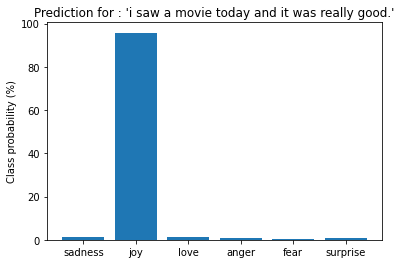

In [ ]:
plt.bar(labels.names, 100 * probs, color="C0")
plt.title(f"Prediction for : '{custom_tweet}'")
plt.ylabel("Class probability (%)")

##Error Analysis

A simple, yet
powerful tool is to sort the validation samples by the model loss. When passing the label during
the forward pass, the loss is automatically calculated and returned. Below is a function that
returns the loss along with the predicted label.

In [ ]:
def forward_pass_with_label(batch):
  input_ids = torch.tensor(batch["input_ids"], device=device)
  attention_mask = torch.tensor(batch["attention_mask"], device=device)
  labels = torch.tensor(batch["label"], device=device)
  print(labels)

  with torch.no_grad():
    output = model(input_ids, attention_mask)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, labels, reduction="none")

  batch["predicted_label"] = pred_label.cpu().numpy()
  batch["loss"] = loss.cpu().numpy()
  return batch

Using the `DatasetDict.map` function once more, we apply the function to get the losses for
all the samples:

In [ ]:
emotions_encoded.reset_format()
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

tensor([0, 0, 2, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1], device='cuda:0')
tensor([0, 3, 2, 1, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0], device='cuda:0')
tensor([1, 0, 0, 1, 0, 0, 3, 1, 2, 0, 0, 0, 3, 0, 0, 3], device='cuda:0')
tensor([2, 0, 0, 1, 1, 0, 1, 1, 3, 0, 0, 2, 2, 1, 0, 1], device='cuda:0')
tensor([1, 0, 0, 2, 4, 0, 1, 1, 1, 4, 2, 1, 0, 3, 0, 0], device='cuda:0')
tensor([0, 3, 3, 0, 3, 2, 1, 1, 2, 3, 3, 1, 2, 3, 4, 1], device='cuda:0')
tensor([3, 3, 2, 0, 3, 2, 2, 0, 1, 3, 0, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 3, 3, 3, 1, 0, 2, 4, 4, 1, 0], device='cuda:0')
tensor([4, 0, 0, 1, 3, 0, 4, 4, 2, 1, 1, 0, 1, 0, 1, 3], device='cuda:0')
tensor([5, 2, 4, 2, 0, 2, 1, 4, 3, 1, 3, 1, 5, 3, 2, 0], device='cuda:0')
tensor([4, 3, 1, 0, 1, 5, 1, 4, 4, 0, 0, 5, 0, 1, 4, 1], device='cuda:0')
tensor([4, 0, 2, 2, 0, 3, 3, 1, 1, 3, 3, 0, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 4, 1, 4, 1, 3, 0, 4, 1, 0, 1, 3, 3], device='cuda:0')
tensor([1, 4, 0, 4, 1, 1, 0, 0, 0, 1, 

Finally, we create a DataFrame with the texts, losses, and the predicted/true labels.

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str, split="test")
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str, split="test"))

In [ ]:
df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.021769
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.021934
2,i feel like a faithful servant,love,love,0.428474
3,i am just feeling cranky and blue,anger,anger,0.029345
4,i can have for a treat or if i am feeling festive,joy,joy,0.022436


We can now easily sort the DataFrame by the losses in either ascending or descending order.

In [ ]:
df_test.sort_values(by=["loss"], ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.655755
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.384926
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.326014
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1950,i as representative of everything thats wrong ...,surprise,sadness,4.977571
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.878881
1801,i feel that he was being overshadowed by the s...,love,sadness,4.834704
1111,im lazy my characters fall into categories of ...,joy,fear,4.702950
1509,i guess this is a memoir so it feels like that...,joy,fear,4.630934
1274,i am going to several holiday parties and i ca...,joy,sadness,4.506275


We can clearly see that the model predicted some of the labels wrong. On the other hand it
seems that there are quite a few examples with no clear class which might be either mislabelled
or require an new class altogether. 

In particular, joy seems to be mislabelled several times. With
this information we can refine the dataset which often can lead to as much or more performance
gain as having more data or larger models!

In [ ]:
df_test.sort_values(by=["loss"], ascending=True).head(10)

,text,label,predicted_label,loss
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016944
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017046
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017291
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017595
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.017609
1310,i feel like an ungrateful asshole,sadness,sadness,0.017713
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017856
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.018021
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.018029
76,i feel like im an unwelcome presence whenever ...,sadness,sadness,0.018094


We now know that the joy is sometimes mislabelled and that the model is most confident about
giving the label sadness. With this information we can make targeted improvements to our dataset and also keep an eye on the class the model seems to be very confident about.

In [ ]:
df_test.sort_values(by=["label"], ascending=True).head(10)

,text,label,predicted_label,loss
1447,i feeling so agitated right now,anger,anger,0.688883
1290,ive spent the last several days feeling irrita...,anger,anger,0.029656
1289,im feeling very distracted today,anger,anger,0.053064
1287,i feel resentful in that i sacrificed alot for...,anger,anger,0.030770
1284,i look in my wallet and i feel a cold chill,anger,anger,0.051482
1279,i am feeling so violent i just fucking shudder...,anger,anger,0.035331
234,im feeling less grumpy after that,anger,anger,0.031395
1277,i will just say that i feel jealous and angry,anger,anger,0.038462
1683,i had applied for a job and they had assured m...,anger,joy,3.749578
1275,i wake up every morning excited about breakfas...,anger,anger,0.037265


In [ ]:
# selecting the true and pred mismatch labels
true_pred_labels_mismatch = df_test[df_test["label"] != df_test["predicted_label"]]

In [ ]:
true_pred_labels_mismatch

,text,label,predicted_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.198635
27,i feel as if i am the beloved preparing hersel...,joy,love,1.772280
35,i am feeling very blessed today that they shar...,joy,love,1.236907
55,i didn t feel accepted,joy,love,0.806654
72,i feel that this is important in itself the fa...,joy,sadness,1.316638
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1964,i feel vaguely cheated and a little amused,joy,anger,3.938705
1987,i feel im supposed to hate dams amp all the co...,joy,anger,1.259942
1993,i feel so tortured by it,anger,fear,0.855164


In [ ]:
true_pred_labels_mismatch.shape

(150, 4)

In [ ]:
len(true_pred_labels_mismatch)

150

So, we have 150 samples that are misclassified.

In [ ]:
# selecting the true and pred mismatch labels
true_pred_labels_mismatch = df_test.loc[df_test["label"] != df_test["predicted_label"]]
true_pred_labels_mismatch

,text,label,predicted_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.198635
27,i feel as if i am the beloved preparing hersel...,joy,love,1.772280
35,i am feeling very blessed today that they shar...,joy,love,1.236907
55,i didn t feel accepted,joy,love,0.806654
72,i feel that this is important in itself the fa...,joy,sadness,1.316638
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,5.279847
1964,i feel vaguely cheated and a little amused,joy,anger,3.938705
1987,i feel im supposed to hate dams amp all the co...,joy,anger,1.259942
1993,i feel so tortured by it,anger,fear,0.855164


##Saving the Model

Finally, we want to save the model so we can reuse it in another session or later if we want to
put it in production. 

We can save the model together with the right tokenizer in the same folder:

In [ ]:
trainer.save_model("models/distilbert-emotion")

Saving model checkpoint to models/distilbert-emotion
Configuration saved in models/distilbert-emotion/config.json
Model weights saved in models/distilbert-emotion/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained("models/distilbert-emotion")

tokenizer config file saved in models/distilbert-emotion/tokenizer_config.json
Special tokens file saved in models/distilbert-emotion/special_tokens_map.json


('models/distilbert-emotion/tokenizer_config.json',
 'models/distilbert-emotion/special_tokens_map.json',
 'models/distilbert-emotion/vocab.txt',
 'models/distilbert-emotion/added_tokens.json',
 'models/distilbert-emotion/tokenizer.json')

The NLP community benefits greatly from sharing pretrained and fine-tuned models, and
everybody can share their models with others via the Hugging Face Model Hub.